In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

In [87]:
data = pd.read_csv('data.csv')
data.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ


In [88]:
# Renaming to a more meaningful name on column Y 
data.rename(columns={'Y':'Quality'}, inplace=True)

In [89]:
print('There are exactly %s rows and %s columns of data' %(data.shape[0],data.shape[1]))

There are exactly 60000 rows and 6 columns of data


In [90]:
# Check missing values in the dataset
data.isnull().sum()

Id              0
Title           0
Body            0
Tags            0
CreationDate    0
Quality         0
dtype: int64

In [91]:
print('The first question recorded is in: %s \nThe last question recorded is in: %s' %(data['CreationDate'].min(),data['CreationDate'].max()))

The first question recorded is in: 2016-01-01 00:21:59 
The last question recorded is in: 2020-02-29 22:45:56


There are no missing values in the dataset

## Examples of each quality post

In [92]:
# High quality post
print('High quality post example: \nTitle: %s \nBody: %s' %(data[data['Quality'] == 'HQ']['Title'].values[0],data[data['Quality'] == 'HQ'][['Body']].values[0]),'\n')

# Low quality post remain open after edits
print('Low quality post remain open after edits example: \nTitle: %s \nBody: %s' %(data[data['Quality'] == 'LQ_EDIT']['Title'].values[0],data[data['Quality'] == 'LQ_EDIT'][['Body']].values[0]),'\n')

# Low quality post closed without a single edit
print('Low quality post closed without a single edit example: \nTitle: %s \nBody: %s' %(data[data['Quality'] == 'LQ_CLOSE']['Title'].values[0],data[data['Quality'] == 'LQ_CLOSE'][['Body']].values[0]),'\n')


High quality post example: 
Title: Why are Java Optionals immutable? 
Body: ["<p>I'd like to understand why Java 8 Optionals were designed to be immutable.  Is it just for thread-safety?</p>\n"] 

Low quality post remain open after edits example: 
Title: How to get all the child records from different tables based on given parent ID in sql server 
Body: ['I am having 4 different tables like \r\nselect * from System \r\n \r\nselect * from Set \r\nselect * from Item \r\nselect * from Versions \r\n\r\nNow for each system Id there will be **n no.of Sets**, and foe **each set** there qill be **n no. of Items** and for **each item** there will be **n no.of Versions**.\r\n\r\n**each system has  <br/>\r\nn no of set <br/>\r\neach Set has <br/>\r\nn no of Items <br/>\r\neach Item has <br/>\r\nn no of Versions**\r\n\r\n\r\nSo, Now when i give **SystemId** then i have to retrieve all the records from \r\n\r\n**Set and Items of each set and Versions of each Items** in single storedprocedure.'] 

L

# Tags Count

In [93]:
data['Tags'].value_counts()[:20]

<python>                      1068
<java>                        1013
<javascript>                   879
<c#>                           672
<c++>                          668
<php>                          564
<c>                            542
<android>                      510
<html><css>                    426
<python><python-3.x>           375
<javascript><jquery>           348
<java><android>                339
<r>                            289
<php><mysql>                   263
<javascript><html>             260
<sql><sql-server>              242
<angular>                      233
<javascript><jquery><html>     156
<python><pandas>               155
<excel><vba>                   148
Name: Tags, dtype: int64

# Quality Counts

In [94]:
data['Quality'].value_counts()

LQ_CLOSE    20000
HQ          20000
LQ_EDIT     20000
Name: Quality, dtype: int64

Wow! They all have the same number of rows.

Here is a graph for a better representation.

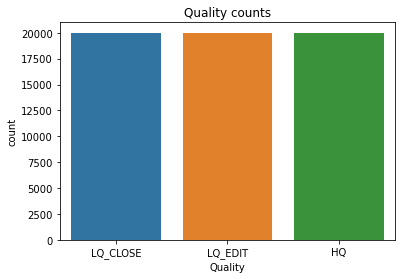

In [95]:
plt.figure()
plt.plot(figsize=(20,5))
sns.countplot(data['Quality'])
plt.title('Quality counts');

In [96]:
data['tags_count'] = data['Tags'].apply(lambda x: len(str(x).split('<')) -1 )

# Tags distribution

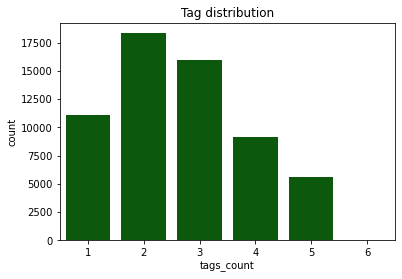

In [97]:
plt.figure()
sns.countplot(data['tags_count'], color = 'darkgreen' );
plt.title("Tag distribution");


### Insights

* The tags distribution is skewed to the right.
* Most questions have 2 tags and the least is 5.


# Questions
* Does long questions result in HQ? (long questsions are more detailed or specific?)
* long questions have more tags?

# Feature-feature interactions

# Text Data Preprocessing

In [98]:
# text preprocessing helper functions
# By: https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert/notebook


def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.
    Apply tokenization and stop word removal
    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [99]:
data['title_clean'] = data['Title'].apply(lambda x: clean_text(x)).apply(lambda x: text_preprocessing(x))
data['body_clean'] = data['Body'].apply(lambda x: clean_text(x)).apply(lambda x: text_preprocessing(x))

In [100]:
data.head()

,Id,Title,Body,Tags,CreationDate,Quality,tags_count,title_clean,body_clean
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,2,java repeat task every random seconds,im already familiar with repeating tasks every...
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT,2,how to get all the child records from differen...,i am having different tables like select from ...
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ,2,why are java optionals immutable,id like to understand why java optionals were ...
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,5,text overlay image with darkened opacity react...,i am attempting to overlay a title over an ima...
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,5,why ternary operator in swift is so picky,the question is very simple but i just could n...


# Look at the number of words in the title and body columns.

In [101]:
data['title_word_count'] = data['title_clean'].apply(lambda x: len(str(x).split()))
data['body_word_count']  = data['body_clean'].apply(lambda x: len(str(x).split()))

In [103]:
data.head()

,Id,Title,Body,Tags,CreationDate,Quality,tags_count,title_clean,body_clean,title_word_count,body_word_count
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,2,java repeat task every random seconds,im already familiar with repeating tasks every...,6,52
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT,2,how to get all the child records from differen...,i am having different tables like select from ...,18,100
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ,2,why are java optionals immutable,id like to understand why java optionals were ...,5,17
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,5,text overlay image with darkened opacity react...,i am attempting to overlay a title over an ima...,8,292
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,5,why ternary operator in swift is so picky,the question is very simple but i just could n...,8,73


# Title Word Counts

In [104]:
data['title_word_count'].max()

33

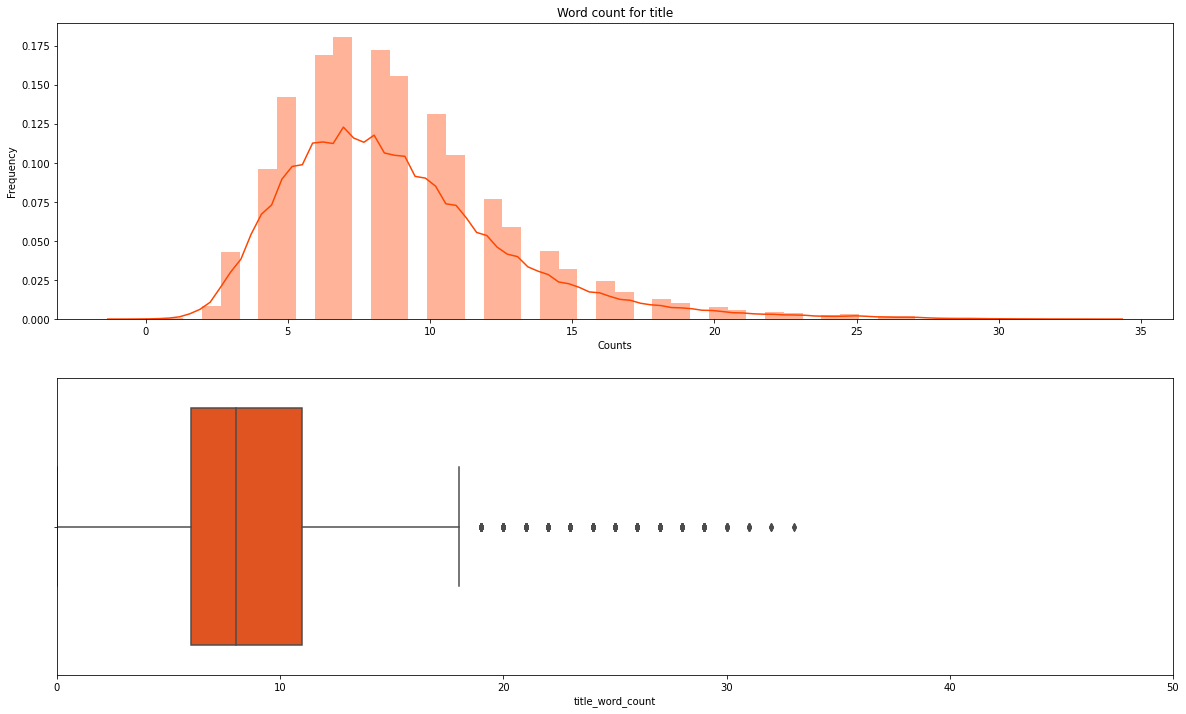

In [105]:
fig, ax = plt.subplots(2,1,figsize=(20,12))

sns.distplot(data['title_word_count'], ax=ax[0], color="orangered", kde=True);
ax[0].set_xlabel('Counts')
ax[0].set_ylabel("Frequency")
ax[0].set_title("Word count for title")

sns.boxplot(data['title_word_count'], ax=ax[1], color='orangered');
ax[1].set_xlim(0,50);

In [106]:
np.quantile(data['title_word_count'], 0.75) - np.quantile(data['title_word_count'], 0.25)

5.0

In [107]:
np.quantile(data['title_word_count'], 0.5)

8.0

In [108]:
print(np.quantile(data['title_word_count'], 0.95))

16.0


### Insights

* For most of the titles we have words range from 5 to 8.
* More than 16 words is very seldom.
* Most number of words in a title is 33.

# Body Word Counts

In [109]:
data['body_word_count'].max()

2906

In [110]:
data['body_word_count'].sort_values(ascending=False).head()

45561    2906
56299    2280
50110    2166
29611    1839
27357    1790
Name: body_word_count, dtype: int64

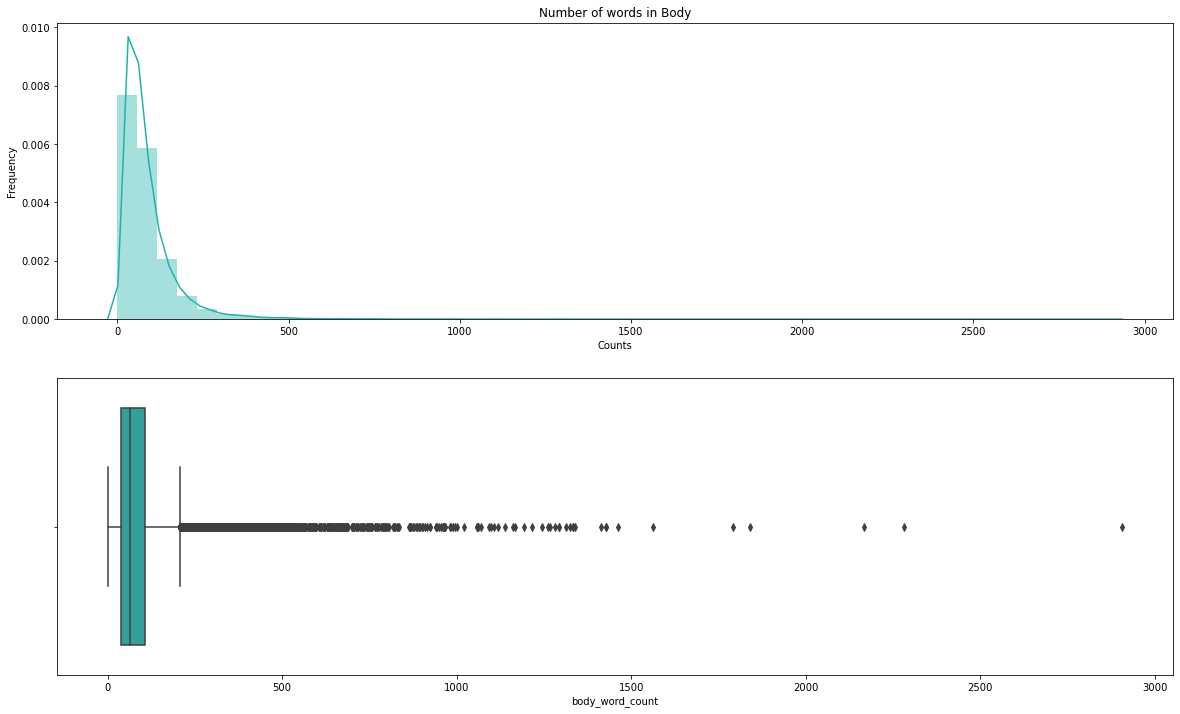

In [111]:
fig, ax = plt.subplots(2,1,figsize=(20,12))

sns.distplot(data['body_word_count'], ax=ax[0], color = 'lightseagreen', kde=True);
ax[0].set_xlabel('Counts')
ax[0].set_ylabel("Frequency")
ax[0].set_title("Number of words in Body")

sns.boxplot(data['body_word_count'], ax=ax[1], color='lightseagreen');


In [112]:
np.quantile(data['body_word_count'], 0.75) - np.quantile(data['body_word_count'], 0.25)

67.0

In [113]:
np.quantile(data['body_word_count'], 0.5)

64.0

In [114]:
print(np.quantile(data['body_word_count'], 0.95))

228.0


### Insights

* On average most of the questions body are between 64 to 67 words long.
* There are hardly with 228 words longer.
* There is one super long question with 2906 words.

In [127]:
hq = data[data['Quality'] == 'HQ']
lq_edit = data[data['Quality'] == 'LQ_EDIT']
lq_close = data[data['Quality'] == 'LQ_CLOSE']

<AxesSubplot:xlabel='body_word_count'>

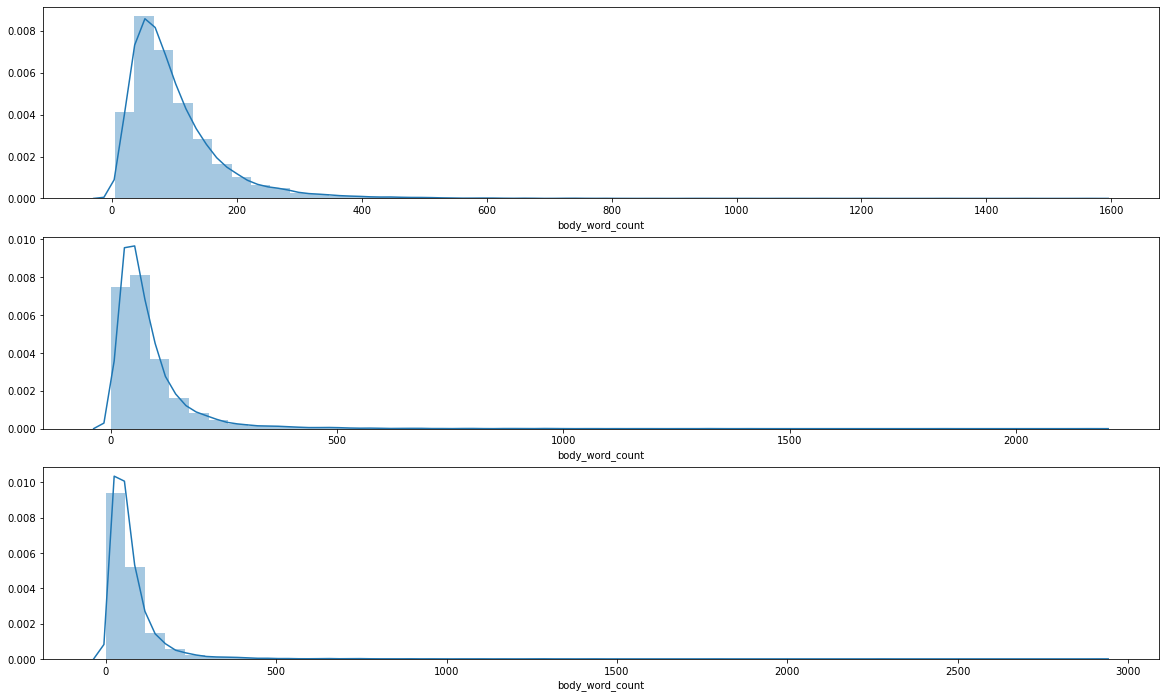

In [128]:
fig, ax = plt.subplots(3,1,figsize=(20,12))
sns.distplot(hq['body_word_count'], ax=ax[0])

sns.distplot(lq_edit['body_word_count'],ax=ax[1])

sns.distplot(lq_close['body_word_count'],ax=ax[2])


In [147]:
sns.histplot(data['body_word_count'], hue=data['Quality'], kind="kde")


AttributeError: module 'seaborn' has no attribute 'histplot'

In [130]:
lq_edit['body_word_count'].max()

2166

In [131]:
lq_close['body_word_count'].max()

2906